### Predicting whether a customer would complete booking 

In [181]:
# Importing necessary libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score,precision_score, precision_recall_curve,confusion_matrix,ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.preprocessing import StandardScaler

In [6]:
# working directory 
os.getcwd()

'/Users/imanuelannoh'

In [231]:
# Importing the dataset 
data = pd.read_csv("customer_booking.csv", encoding='latin1')
data.head(5)
data.shape

(50000, 14)

In [10]:
# Checking data types 
data.dtypes

num_passengers             int64
sales_channel             object
trip_type                 object
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                object
route                     object
booking_origin            object
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
booking_complete           int64
dtype: object

In [12]:
# Chekcing for missing values 
data.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

In [14]:
# Distribution of data and summary statistics 
data.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


In [42]:
# Distribution of trip_type and whether a passenger completed thier booking
counts = data.groupby(["trip_type", "booking_complete"]).size().unstack(fill_value=0)
counts["Proportions completed"] = counts[1]/ (counts[0] + counts[1])
counts = counts.rename(columns = {0 : "Not completed", 1 : "Completed"})
counts

booking_complete,Not completed,Completed,Proportions completed
trip_type,,,
CircleTrip,111,5,0.043103
OneWay,367,20,0.051680
RoundTrip,42044,7453,0.150575


In [44]:
# Distribution of trip_type and whether a passenger completed thier booking
counts = data.groupby(["flight_day", "booking_complete"]).size().unstack(fill_value=0)
counts["Proportions completed"] = counts[1]/ (counts[0] + counts[1])
counts = counts.rename(columns = {0 : "Not completed", 1 : "Completed"})
counts

booking_complete,Not completed,Completed,Proportions completed
flight_day,,,
Fri,5778,983,0.145393
Mon,6898,1204,0.148605
Sat,4951,861,0.148142
Sun,5627,927,0.141440
Thu,6302,1122,0.151131
Tue,6544,1129,0.147139
Wed,6422,1252,0.163148


<Axes: xlabel='booking_complete', ylabel='count'>

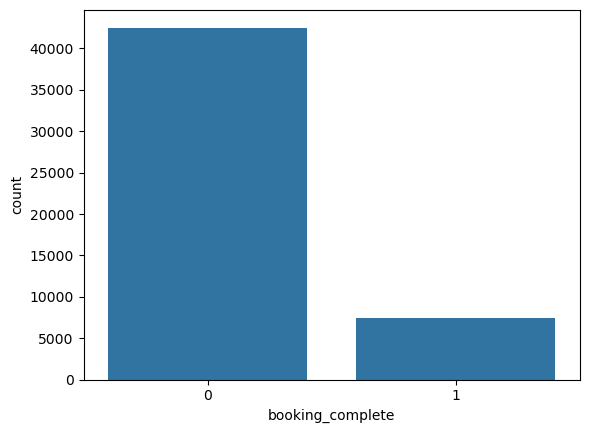

In [46]:
# Count of booking_completed
sns.countplot(x = "booking_complete", data = data)

from the countplot there are as many as 4x the number of users the did not complete their booking to those that did. The class imbalance here might affect how effective the model is
potential solution could be SMOTE or just hyperparamter tuning for some classification algorithms

In [79]:
# Dropping columns that dont help predict the target variable 
# Investing the numerical columns with the dichotomous target variable using point biserial correlation
from scipy.stats import pointbiserialr 
num_columns = data.select_dtypes(include =["float64","int64"]).columns

for col in num_columns:
    corr,pval = pointbiserialr(data[col],data["booking_complete"])
    print(f'For the column {col}, correlation : {corr} and the pvalue: {pval}')


For the column num_passengers, correlation : 0.024116223907282984 and the pvalue: 6.92134227024434e-08
For the column purchase_lead, correlation : -0.022130736497937592 and the pvalue: 7.457066331779355e-07
For the column length_of_stay, correlation : -0.04240798189570918 and the pvalue: 2.3836439467389562e-21
For the column flight_hour, correlation : 0.007127304978578301 and the pvalue: 0.11100453516089634
For the column wants_extra_baggage, correlation : 0.06813851005648788 and the pvalue: 1.5584330370129179e-52
For the column wants_preferred_seat, correlation : 0.05011595841664214 and the pvalue: 3.5191689312549883e-29
For the column wants_in_flight_meals, correlation : 0.026510810682322472 and the pvalue: 3.0498700652044788e-09
For the column flight_duration, correlation : -0.10626610443248123 and the pvalue: 1.6831449989329325e-125
For the column booking_complete, correlation : 1.0 and the pvalue: 0.0


In [81]:
# Dropping flight hour column since there the pvalue showed no statistical significance with target variable 
data = data.drop("flight_hour",axis = 1)

In [87]:
# Investigating the relationship of the categorical columns with the dichotoouts target variable 
from scipy.stats import chi2_contingency 
cat_columns = data.select_dtypes(include = "object").columns 

for col in cat_columns:
    contigency_table = pd.crosstab(data[col], data["booking_complete"])
    chi2,p,dof,expected = chi2_contingency(contigency_table)
    print(f'For the column {col}, pvalue : {p}')



For the column sales_channel, pvalue : 5.123094421404519e-20
For the column trip_type, pvalue : 2.181116284042331e-09
For the column flight_day, pvalue : 0.01318519205100082
For the column route, pvalue : 0.0
For the column booking_origin, pvalue : 0.0


All pvalues are less than than 0.05 hence we can reject the null hypothesis (no relationship between the columns) 

In [98]:
# Checking for high cardinality columns which could explode the dimensional space of my dataset 
for col in cat_columns:
    print(f' {col} has {data[col].nunique()} values')

 sales_channel has 2 values
 trip_type has 3 values
 flight_day has 7 values
 route has 799 values
 booking_origin has 104 values


Route and booking origin are high cardinal columns 


In [108]:
# Dealing with route and booking origin columns 
freq_map = data["booking_origin"].value_counts().to_dict()
data["booking_origin_freq"] = data["booking_origin"].map(freq_map) 

freq_maps = data["route"].value_counts().to_dict()
data["route_freq"] = data["route"].map(freq_maps) 

In [137]:
# Converting cat_columns to numerical columns 
cat_columns_1 = data.select_dtypes(include = "object").columns
cat_columns_2 = cat_columns_1.drop(["booking_origin","route"])
cat_dummies = pd.get_dummies(data[cat_columns_2], drop_first = True)
data = data.drop(columns = cat_columns_1)
data = pd.concat([data,cat_dummies],axis = 1)


In [143]:
# Splitting the dataset into X and y 
X = data.drop("booking_complete", axis = 1) 
y = data["booking_complete"]

In [147]:
# train test split the data 
X_train, X_test, y_train,y_test  = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify = y) 

In [149]:
# Standardizing the numerical columns 
numerical_col_train = X_train.select_dtypes(include = ["float64","int64"]).columns
numerical_col_test = X_test.select_dtypes(include = ["float64","int64"]).columns
std = StandardScaler() 
X_train[numerical_col_train] = std.fit_transform(X_train[numerical_col_train])
X_test[numerical_col_test] = std.transform(X_test[numerical_col_test])

In [163]:
# Logistic Regression (initial baseline model )
lr = LogisticRegression(class_weight="balanced") 
lr.fit(X_train,y_train)

LogisticRegression(class_weight='balanced')

In [165]:
# Model evaluation 
y_test_pred_lr = lr.predict(X_test)

accuracy_score_lr = accuracy_score(y_test, y_test_pred_lr)
recall_score_lr  = recall_score(y_test, y_test_pred_lr)
precision_score_lr = precision_score(y_test, y_test_pred_lr)
f1_score_lr = f1_score(y_test, y_test_pred_lr)

# Print metrics 
print(f'accuracy score : {accuracy_score_lr}')
print(f'recall score : {recall_score_lr}')
print(f'precision score : {precision_score_lr}')
print(f'f1_score score : {f1_score_lr}')


accuracy score : 0.5905
recall score : 0.7065508021390374
precision score : 0.22427328665393592
f1_score score : 0.34047350620067646


In [177]:
# Random Forest ( inital baseline model ) 
rf = RandomForestClassifier(class_weight = "balanced")
rf.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced')

In [179]:
# Model evaluation 
y_test_pred_rf = rf.predict(X_test)

accuracy_score_rf = accuracy_score(y_test, y_test_pred_rf)
recall_score_rf  = recall_score(y_test, y_test_pred_rf)
precision_score_rf = precision_score(y_test, y_test_pred_rf)
f1_score_rf = f1_score(y_test, y_test_pred_rf)

# Print metrics 
print(f'accuracy score : {accuracy_score_rf}')
print(f'recall score : {recall_score_rf}')
print(f'precision score : {precision_score_rf}')
print(f'f1_score score : {f1_score_rf}')


accuracy score : 0.8514
recall score : 0.11497326203208556
precision score : 0.5149700598802395
f1_score score : 0.18797814207650274


In [185]:
y.value_counts()
scale_pos_weight = 42522 / 7478
scale_pos_weight

5.6862797539449055

In [189]:
# XgBoost (inital baseline model) 
xgb = XGBClassifier(scale_pos_weight = 5.6863)
xgb.fit(X_train, y_train) 


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [191]:
# Model evaluation 
y_test_pred_xgb = xgb.predict(X_test)

accuracy_score_xgb = accuracy_score(y_test, y_test_pred_xgb)
recall_score_xgb  = recall_score(y_test, y_test_pred_xgb)
precision_score_xgb = precision_score(y_test, y_test_pred_xgb)
f1_score_xgb = f1_score(y_test, y_test_pred_xgb)

# Print metrics 
print(f'accuracy score : {accuracy_score_xgb}')
print(f'recall score : {recall_score_xgb}')
print(f'precision score : {precision_score_xgb}')
print(f'f1_score score : {f1_score_xgb}')


accuracy score : 0.7358
recall score : 0.6951871657754011
precision score : 0.32238065716057035
f1_score score : 0.4404913172384583


- **Takeaway from the inital baseline comparisons**
  
The XGBoost classifier appears to be the most promising model, as it delivers the highest F1 score among the binary classifiers tested. Since the goal is to predict whether a passenger is likely to complete their booking — in order to target ads, campaigns, and perks more effectively — precision is particularly important; I want to minimize the risk of allocating resources to passengers who ultimately do not convert. However, I chose to focus on the F1 score as the primary evaluation metric to maintain a reasonable balance between precision and recall, ensuring that the model captures a meaningful portion of true positives while still making accurate positive predictions.

In [201]:
# Hyperparameter tuning XGBoost Classifer 
params_grid =  {'n_estimators' : [100,300,500],
                'max_depth' : [3,5,7,9],
                'learning_rate' : [0.05,0.1],
                'subsample' : [0.6,0.8,1]}

In [203]:
# GridSearchCV 
grid_search = GridSearchCV(xgb, params_grid, cv=5, scoring = 'f1')
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.05, 0.1],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [100, 300, 500],
                         'subsample': [0.6, 0.8, 1]},
             scoring='f1')

In [207]:
# Model Evaluation on XGB with grid Search CV
best_model = grid_search.best_estimator_ 
y_test_pred_xgb = best_model.predict(X_test)

accuracy_score_xgb = accuracy_score(y_test, y_test_pred_xgb)
recall_score_xgb  = recall_score(y_test, y_test_pred_xgb)
precision_score_xgb = precision_score(y_test, y_test_pred_xgb)
f1_score_xgb = f1_score(y_test, y_test_pred_xgb)

# Print metrics 
print(f'accuracy score : {accuracy_score_xgb}')
print(f'recall score : {recall_score_xgb}')
print(f'precision score : {precision_score_xgb}')
print(f'f1_score score : {f1_score_xgb}')

accuracy score : 0.7181
recall score : 0.7219251336898396
precision score : 0.31007751937984496
f1_score score : 0.43382205262100826



### Model Interpretation 
- Feature Importance to see how each variable contributes to the predictive model’s power

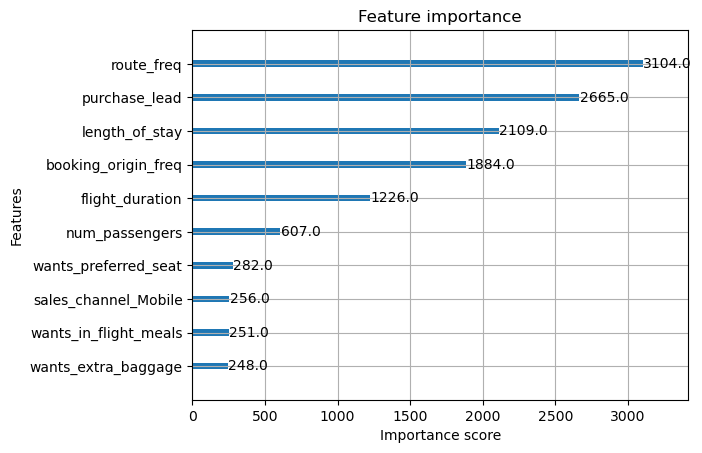

In [214]:
from xgboost import plot_importance 
plot_importance(best_model, max_num_features = 10)
plt.show()

The most important predictors of booking completion were route_freq, purchase_lead, and length_of_stay, suggesting that route popularity and traveler planning behavior are key indicators. Passenger preferences such as wanting meals or extra baggage also contributed modestly

In [219]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 546.9/546.9 kB 216.4 kB/s eta 0:00:00:--:--


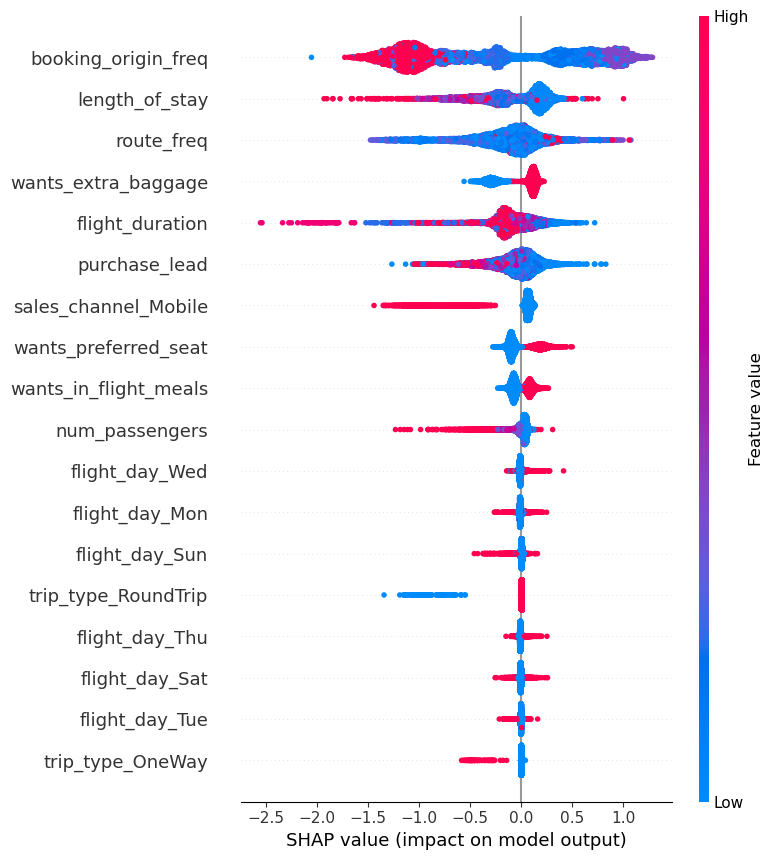

In [221]:
import shap

# Create SHAP explainer
explainer = shap.Explainer(best_model)

# Get SHAP values for X_test
shap_values = explainer(X_test)

# Summary plot: global feature importance
shap.summary_plot(shap_values, X_test)

The SHAP summary plot reveals which features most influenced the model’s predictions of booking completion and how they did so. Features like booking_origin_freq and route_freq had the strongest impact, with higher frequencies generally pushing the model toward predicting a completed booking. Preferences such as wanting a preferred seat or extra baggage also increased the likelihood of completion, as shown by positive SHAP values for high feature values (red dots to the right). Conversely, passengers who booked far in advance (purchase_lead) were less likely to complete, while last-minute bookers were more likely to follow through. Some features, like length_of_stay, had minimal overall impact but showed that longer stays slightly increased the chance of booking completion. Overall, the plot helps identify not just which features matter most, but how their values influence individual predictions.

In [229]:
import joblib
joblib.dump(best_model, 'xgb_booking_model.pkl')

['xgb_booking_model.pkl']